# Notebook Capítulo Empírico

Abaixo um roteiro em células de notebook que cobre:

1. Importação de pacotes
2. Carregar os dados JSON
3. Unir datasets (merge por data)
4. Criar retorno mensal do IBOV (%)
5. Estatísticas descritivas
6. Gráficos comparativos
7. Regressão Linear Simples (modelo principal)
8. Gráfico de dispersão com linha de regressão
9. Análise complementar: SELIC Meta (% a.a.)


## 0. Extrair e preparar os dados

In [2]:
from pathlib import Path
import sys

PROJECT_ROOT = Path.cwd().resolve()
SRC_DIR = PROJECT_ROOT / "src"
if SRC_DIR.exists() and str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

from ibovselic import MarketDataExporter

output_dir = PROJECT_ROOT / "data" / "raw"
output_dir.mkdir(parents=True, exist_ok=True)

inicio_analise = 2009
fim_analise = 2024

exporter = MarketDataExporter(data_dir=output_dir)

exporter.export_selic_meta(inicio_analise, fim_analise)
exporter.export_selic(inicio_analise, fim_analise)
exporter.export_ibov(inicio_analise, fim_analise)


[2025-10-27 22:29:31,316] [INFO] Starting export for SELIC serie 4392 (2009-2024)
[2025-10-27 22:29:31,316] [INFO] Requesting block 2009-2018
[2025-10-27 22:29:31,739] [INFO] Requesting block 2019-2024
[2025-10-27 22:29:32,143] [INFO] Done. Saved 192 entries to C:\Users\crist\Documents\projetos\py_selic_ibov\notebooks\data\raw\history_selic_meta.json
[2025-10-27 22:29:32,144] [INFO] Starting export for SELIC serie 4390 (2009-2024)
[2025-10-27 22:29:32,144] [INFO] Requesting block 2009-2018
[2025-10-27 22:29:32,504] [INFO] Requesting block 2019-2024
[2025-10-27 22:29:32,871] [INFO] Done. Saved 192 entries to C:\Users\crist\Documents\projetos\py_selic_ibov\notebooks\data\raw\history_selic.json
[2025-10-27 22:29:32,873] [INFO] Starting export for IBOVESPA (2009-2024)
[2025-10-27 22:29:32,873] [INFO] Requesting block 2009-2018
[2025-10-27 22:29:33,335] [INFO] Requesting block 2019-2024
[2025-10-27 22:29:33,856] [INFO] Done. Saved 192 entries to C:\Users\crist\Documents\projetos\py_selic_ib

WindowsPath('C:/Users/crist/Documents/projetos/py_selic_ibov/notebooks/data/raw/history_ibov.json')

## 1. Importação de pacotes

In [4]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm


## 2. Carregar os dados JSON

In [5]:
pasta_arquivos= Path("data/raw")
ibov = pd.read_json(pasta_arquivos / "history_ibov.json")               # Ibov Acumulado
selic = pd.read_json(pasta_arquivos / "history_selic.json")             # acumulada % a.m.
selic_meta = pd.read_json(pasta_arquivos / "history_selic_meta.json")   # meta % a.a.

# Converter datas
for df in [ibov, selic, selic_meta]:
    df["date_reference"] = pd.to_datetime(df["date_reference"])

# Renomear colunas de valor
ibov = ibov.rename(columns={"value": "ibov"})
selic = selic.rename(columns={"value": "selic_mensal"})
selic_meta = selic_meta.rename(columns={"value": "selic_meta"})


## 3. Unir datasets (merge por data)

In [6]:
df = (
    ibov[["date_reference","ibov"]]
    .merge(selic[["date_reference","selic_mensal"]], on="date_reference")
    .merge(selic_meta[["date_reference","selic_meta"]], on="date_reference")
)

#ibov return
df["ibov_return"] = df["ibov"].pct_change() * 100
df = df.dropna().reset_index(drop=True)

df.head(10)


,date_reference,ibov,selic_mensal,selic_meta,ibov_return
0,2009-02-01,38183.31,0.86,12.62,-2.843403
1,2009-03-01,40925.87,0.97,11.65,7.182615
2,2009-04-01,47289.53,0.84,11.05,15.549236
3,2009-05-01,53197.73,0.77,10.10,12.493675
4,2009-06-01,51465.46,0.76,9.40,-3.256286
5,2009-07-01,54765.72,0.79,8.93,6.412573
6,2009-08-01,56488.98,0.69,8.62,3.146603
7,2009-09-01,61517.89,0.69,8.62,8.902462
8,2009-10-01,61545.50,0.69,8.62,0.044881
9,2009-11-01,67044.44,0.66,8.63,8.934756


## 4. Modelo de defasagens distribuídas (Distributed lag models)

In [31]:
periodo_defasagem = 12 # número de meses
for k in range(0, periodo_defasagem+1):
    df[f"selic_meta_m{k}"] = df["selic_meta"].shift(k)

lags_meta = [f"selic_l{k}" for k in range(0,periodo_defasagem+1)]


In [27]:
df.head(10)

,date_reference,ibov,selic_mensal,selic_meta,ibov_return,selic_meta_m0,selic_meta_m1,selic_meta_m2,selic_meta_m3,selic_meta_m4,selic_meta_m5,selic_meta_m6,selic_meta_m7,selic_meta_m8,selic_meta_m9,selic_meta_m10,selic_meta_m11,selic_meta_m12
0,2009-02-01,38183.31,0.86,12.62,-2.843403,12.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2009-03-01,40925.87,0.97,11.65,7.182615,11.65,12.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2009-04-01,47289.53,0.84,11.05,15.549236,11.05,11.65,12.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2009-05-01,53197.73,0.77,10.10,12.493675,10.10,11.05,11.65,12.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2009-06-01,51465.46,0.76,9.40,-3.256286,9.40,10.10,11.05,11.65,12.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2009-07-01,54765.72,0.79,8.93,6.412573,8.93,9.40,10.10,11.05,11.65,12.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2009-08-01,56488.98,0.69,8.62,3.146603,8.62,8.93,9.40,10.10,11.05,11.65,12.62,NaN,NaN,NaN,NaN,NaN,NaN
7,2009-09-01,61517.89,0.69,8.62,8.902462,8.62,8.62,8.93,9.40,10.10,11.05,11.65,12.62,NaN,NaN,NaN,NaN,NaN
8,2009-10-01,61545.50,0.69,8.62,0.044881,8.62,8.62,8.62,8.93,9.40,10.10,11.05,11.65,12.62,NaN,NaN,NaN,NaN
9,2009-11-01,67044.44,0.66,8.63,8.934756,8.63,8.62,8.62,8.62,8.93,9.40,10.10,11.05,11.65,12.62,NaN,NaN,NaN


## 5. Estatísticas descritivas

In [22]:
print(df[["ibov","ibov_return","selic_mensal","selic_meta"]].describe())

# Correlação
print("\nCorrelação:")
print(df[["ibov","ibov_return","selic_mensal","selic_meta"]].corr())


                ibov  ibov_return  selic_mensal  selic_meta
count     191.000000   191.000000    191.000000  191.000000
mean    79440.877874     0.782221      0.754660    9.493037
std     27308.688385     6.202850      0.265682    3.381905
min     38183.310000   -29.904330      0.130000    1.900000
25%     56290.735000    -3.293862      0.550000    6.950000
50%     67705.400000     0.645050      0.800000   10.320000
75%    104783.880000     4.842147      0.950000   12.070000
max    136004.010000    16.968345      1.220000   14.140000

Correlação:
                  ibov  ibov_return  selic_mensal  selic_meta
ibov          1.000000     0.059914     -0.282217   -0.279058
ibov_return   0.059914     1.000000     -0.021278   -0.017868
selic_mensal -0.282217    -0.021278      1.000000    0.981174
selic_meta   -0.279058    -0.017868      0.981174    1.000000


## 6. Gráficos comparativos

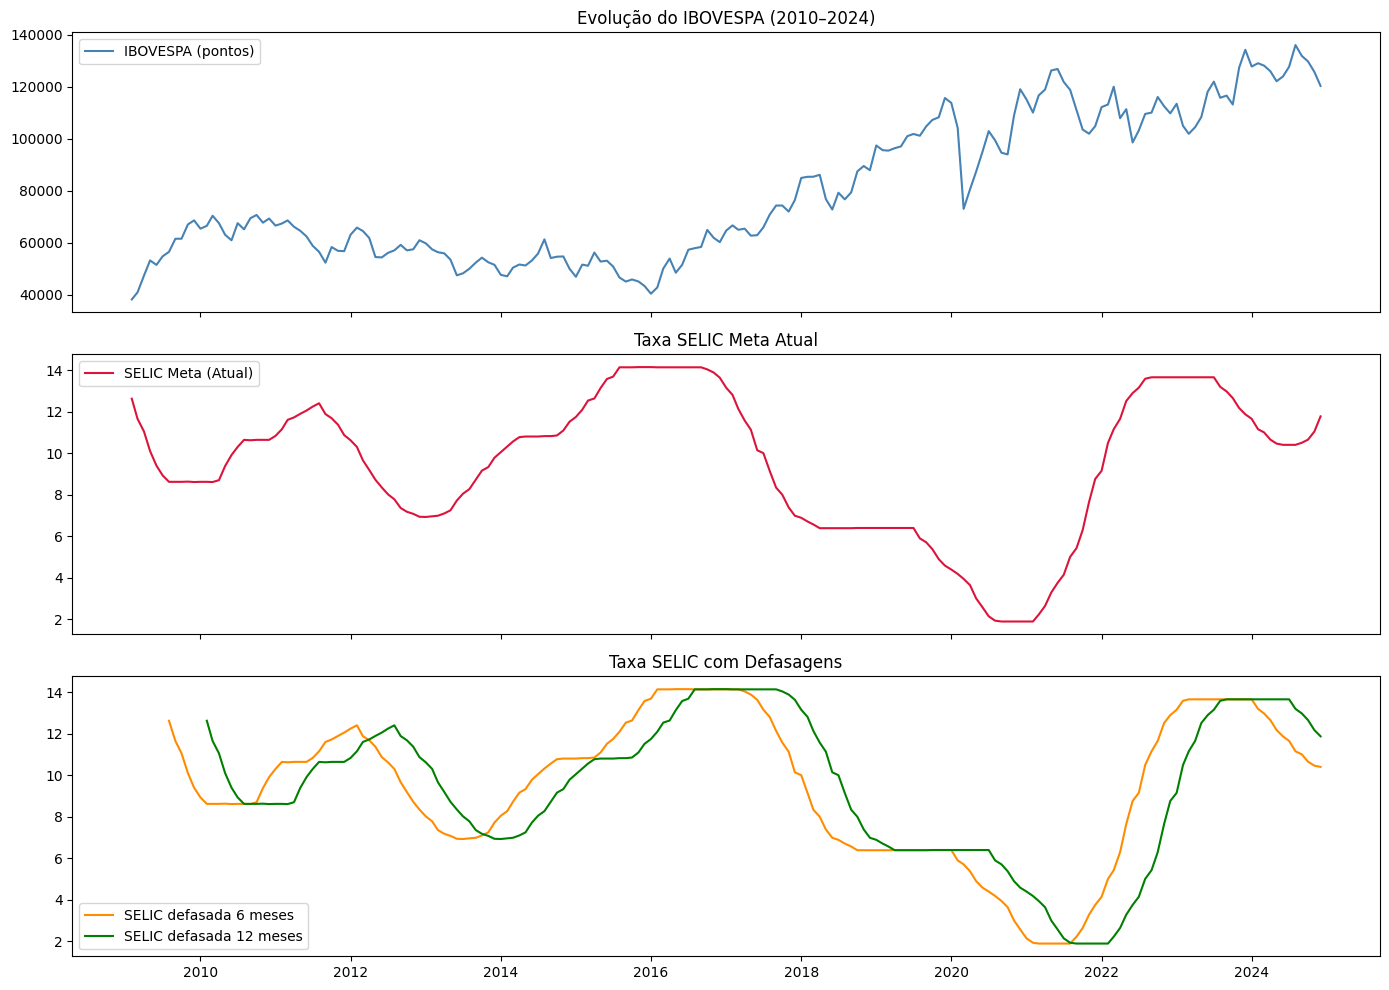

In [28]:
# --- Visualização da série temporal ---
fig, ax = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Ibovespa
ax[0].plot(df["date_reference"], df["ibov"], label="IBOVESPA (pontos)", color="steelblue")
ax[0].set_title("Evolução do IBOVESPA (2010–2024)", fontsize=12)
ax[0].legend()

# SELIC atual
ax[1].plot(df["date_reference"], df["selic_meta"], label="SELIC Meta (Atual)", color="crimson")
ax[1].set_title("Taxa SELIC Meta Atual", fontsize=12)
ax[1].legend()

# SELIC defasada em 6 e 12 meses
ax[2].plot(df["date_reference"], df["selic_meta_m6"], label="SELIC defasada 6 meses", color="darkorange")
ax[2].plot(df["date_reference"], df["selic_meta_m12"], label="SELIC defasada 12 meses", color="green")
ax[2].set_title("Taxa SELIC com Defasagens", fontsize=12)
ax[2].legend()

plt.tight_layout()
plt.show()



## 7. Regressão Linear Simples (modelo principal)

In [33]:
# Seleciona as variáveis m0 até m12
lags_m = [f"selic_meta_m{k}" for k in range(0, periodo_defasagem + 1)]

# Monta X e Y, garantindo alinhamento temporal
X = sm.add_constant(df[lags_m].dropna())
y = df["ibov"].iloc[len(df) - len(X):]

# Estima o modelo DLM
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                   ibov   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     1.953
Date:                Mon, 27 Oct 2025   Prob (F-statistic):             0.0277
Time:                        20:46:02   Log-Likelihood:                -2069.5
No. Observations:                 179   AIC:                             4167.
Df Residuals:                     165   BIC:                             4212.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1.136e+05   7236.720     15.

## 8. Gráfico de dispersão com linha de regressão

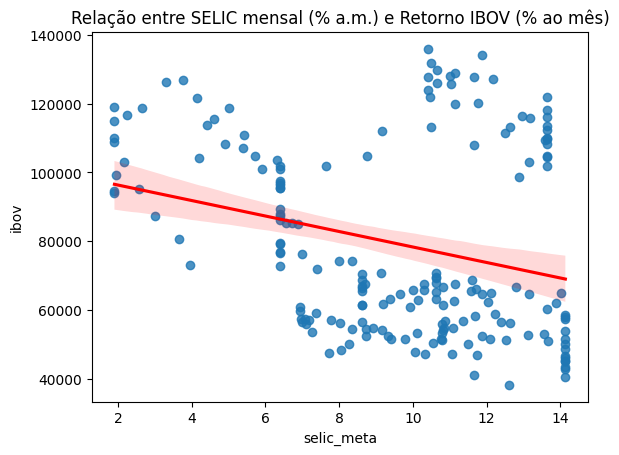

In [27]:
sns.regplot(x="selic_meta", y="ibov", data=df, ci=95, line_kws={"color":"red"})
plt.title("Relação entre SELIC mensal (% a.m.) e Retorno IBOV (% ao mês)")
plt.show()